In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FixedLocator
import os

In [2]:
cuda_df = pd.read_csv("cuda_performance_results.csv")
print(cuda_df.head())

          test_type  num_operations  run  time_ms  batch_size
0  single_insertion             100    1       12           1
1  single_insertion             100    2       11           1
2  single_insertion             100    3       12           1
3  single_insertion             100    4       11           1
4  single_insertion             100    5       11           1


In [3]:
# Group the data by test_type, num_operations, and batch_size
cuda_grouped = cuda_df.groupby(['test_type', 'num_operations', 'batch_size']).agg(
    mean_time_ms=('time_ms', 'mean'),
    std_time_ms=('time_ms', 'std')
).reset_index()

print(cuda_grouped)

            test_type  num_operations  batch_size  mean_time_ms  std_time_ms
0    batch_extraction            1000          64           0.4     0.547723
1    batch_extraction            1000         128           0.0     0.000000
2    batch_extraction            1000         256           0.0     0.000000
3    batch_extraction           10000          64          11.8     0.447214
4    batch_extraction           10000         128           5.8     0.447214
5    batch_extraction           10000         256           2.6     0.547723
6    batch_extraction          100000          64         471.0     3.391165
7    batch_extraction          100000         128         236.0     2.549510
8    batch_extraction          100000         256         117.8     1.095445
9     batch_insertion            1000          64           3.4     0.547723
10    batch_insertion            1000         128           1.0     0.000000
11    batch_insertion            1000         256           0.4     0.547723

In [4]:
ref_df = pd.read_csv("ref_performance_results.csv")
print(ref_df.head())

          test_type  num_operations  run  time_ms  batch_size
0  single_insertion             100    1      0.0           1
1  single_insertion             100    2      0.0           1
2  single_insertion             100    3      0.0           1
3  single_insertion             100    4      0.0           1
4  single_insertion             100    5      0.0           1


In [5]:
ref_grouped = ref_df.groupby(['test_type', 'num_operations', 'batch_size']).agg(
    mean_time_ms=('time_ms', 'mean'),
    std_time_ms=('time_ms', 'std')
).reset_index()

print(ref_grouped)

            test_type  num_operations  batch_size  mean_time_ms   std_time_ms
0    batch_extraction            1000          64           0.0      0.000000
1    batch_extraction            1000         128           0.0      0.000000
2    batch_extraction            1000         256           0.0      0.000000
3    batch_extraction           10000          64           0.0      0.000000
4    batch_extraction           10000         128           0.0      0.000000
5    batch_extraction           10000         256           0.0      0.000000
6    batch_extraction          100000          64          13.0      0.000000
7    batch_extraction          100000         128           7.0      0.000000
8    batch_extraction          100000         256           4.0      0.000000
9     batch_insertion            1000          64           1.0      0.000000
10    batch_insertion            1000         128           0.0      0.000000
11    batch_insertion            1000         256           0.0 

In [6]:
# Add implementation identifier
ref_grouped['implementation'] = 'Reference'
cuda_grouped['implementation'] = 'CUDA'

combined_df = pd.concat([ref_grouped, cuda_grouped], ignore_index=True)

print(combined_df)

            test_type  num_operations  batch_size  mean_time_ms   std_time_ms  \
0    batch_extraction            1000          64           0.0      0.000000   
1    batch_extraction            1000         128           0.0      0.000000   
2    batch_extraction            1000         256           0.0      0.000000   
3    batch_extraction           10000          64           0.0      0.000000   
4    batch_extraction           10000         128           0.0      0.000000   
5    batch_extraction           10000         256           0.0      0.000000   
6    batch_extraction          100000          64          13.0      0.000000   
7    batch_extraction          100000         128           7.0      0.000000   
8    batch_extraction          100000         256           4.0      0.000000   
9     batch_insertion            1000          64           1.0      0.000000   
10    batch_insertion            1000         128           0.0      0.000000   
11    batch_insertion       

In [7]:
# Pivot the DataFrame
pivot_df = combined_df.pivot_table(
    index=['test_type', 'num_operations', 'batch_size'],
    columns='implementation',
    values='mean_time_ms'
).reset_index()

# Rename columns for clarity
pivot_df = pivot_df.rename(columns={'Reference': 'mean_time_ms_ref', 'CUDA': 'mean_time_ms_cuda'})

# Display the pivoted DataFrame
print(pivot_df)

implementation          test_type  num_operations  batch_size  \
0                batch_extraction            1000          64   
1                batch_extraction            1000         128   
2                batch_extraction            1000         256   
3                batch_extraction           10000          64   
4                batch_extraction           10000         128   
5                batch_extraction           10000         256   
6                batch_extraction          100000          64   
7                batch_extraction          100000         128   
8                batch_extraction          100000         256   
9                 batch_insertion            1000          64   
10                batch_insertion            1000         128   
11                batch_insertion            1000         256   
12                batch_insertion           10000          64   
13                batch_insertion           10000         128   
14                batch_i

In [8]:
# Calculate speedup
pivot_df['speedup'] = pivot_df['mean_time_ms_ref'] / pivot_df['mean_time_ms_cuda']

# Handle division by zero or NaN
pivot_df['speedup'] = pivot_df['speedup'].replace([np.inf, -np.inf], np.nan)

# Optionally, calculate percentage improvement
pivot_df['percent_improvement'] = (pivot_df['speedup'] - 1) * 100

# Display the updated DataFrame
print(pivot_df[['test_type', 'num_operations', 'batch_size', 'mean_time_ms_ref', 'mean_time_ms_cuda', 'speedup', 'percent_improvement']])


implementation          test_type  num_operations  batch_size  \
0                batch_extraction            1000          64   
1                batch_extraction            1000         128   
2                batch_extraction            1000         256   
3                batch_extraction           10000          64   
4                batch_extraction           10000         128   
5                batch_extraction           10000         256   
6                batch_extraction          100000          64   
7                batch_extraction          100000         128   
8                batch_extraction          100000         256   
9                 batch_insertion            1000          64   
10                batch_insertion            1000         128   
11                batch_insertion            1000         256   
12                batch_insertion           10000          64   
13                batch_insertion           10000         128   
14                batch_i

In [15]:
sns.set(style="whitegrid")
def plot_speedup(pivot_df, plot_dir="plots"):
    """
    Generates and saves speedup bar plots comparing CUDA over Reference implementations
    for each test_type and batch_size.

    Parameters:
    - pivot_df (pd.DataFrame): Pivoted DataFrame with speedup calculations.
    - plot_dir (str): Directory path where plots will be saved.
    """
    # Get unique test types
    test_types = pivot_df['test_type'].unique()
    
    for test in test_types:
        # Filter data for the current test_type
        test_df = pivot_df[pivot_df['test_type'] == test]
        
        # Check if there are multiple batch_sizes
        if test_df['batch_size'].nunique() > 1:
            # Multiple batch_sizes: create separate subplots
            batch_sizes = sorted(test_df['batch_size'].unique())
            n_batches = len(batch_sizes)
            
            # Determine subplot grid size
            cols = 2
            rows = int(np.ceil(n_batches / cols))
            
            fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharey=True)
            axes = axes.flatten()
            
            for i, batch in enumerate(batch_sizes):
                batch_df = test_df[test_df['batch_size'] == batch].dropna(subset=['speedup'])
                
                if batch_df.empty:
                    axes[i].set_visible(False)
                    continue
                
                # Sort by num_operations for consistent ordering
                batch_df = batch_df.sort_values('num_operations')
                
                # Number of unique num_operations
                num_ops = batch_df['num_operations'].unique()
                x_positions = range(len(num_ops))
                
                # Create bar plot
                sns.barplot(
                    data=batch_df,
                    x='num_operations',
                    y='speedup',
                    ax=axes[i],
                    color='skyblue'
                )
                
                # Set fixed locator and tick labels
                axes[i].xaxis.set_major_locator(FixedLocator(x_positions))
                axes[i].set_xticklabels([f"{int(tick):,}" for tick in num_ops])
                
                # Add labels on top of each bar
                for j, (_, row) in enumerate(batch_df.iterrows()):
                    axes[i].text(
                        j, 
                        row['speedup'] + 0.05, 
                        f"{row['speedup']:.2f}x", 
                        ha='center', 
                        va='bottom',
                        fontsize=10
                    )
                
                # Customize subplot
                axes[i].set_title(f'{test} - Batch Size {batch}')
                axes[i].set_xlabel('Number of Operations')
                axes[i].set_ylabel('Speedup (Ref/CUDA)')
                axes[i].set_ylim(0, batch_df['speedup'].max() + 1)
            
            # Remove any unused subplots
            for j in range(i + 1, len(axes)):
                fig.delaxes(axes[j])
            
            # Overall title
            fig.suptitle(f'Speedup of CUDA over Reference for {test}', fontsize=18)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])
            
            # Save the entire figure with multiple subplots
            overall_plot_filename = f"{test}_all_batches_speedup.png"
            overall_plot_path = os.path.join(plot_dir, overall_plot_filename)
            plt.savefig(overall_plot_path)
            print(f"Saved overall plot for {test}: {overall_plot_path}")
            
            # Show the plot
            plt.show()
        
        else:
            # Single batch_size: create a single plot
            batch_size = test_df['batch_size'].unique()[0]
            plot_df = test_df.dropna(subset=['speedup'])
            
            if plot_df.empty:
                print(f"No speedup data available for {test} with batch size {batch_size}.")
                continue
            
            # Sort by num_operations
            plot_df = plot_df.sort_values('num_operations')
            
            # Number of unique num_operations
            num_ops = plot_df['num_operations'].unique()
            x_positions = range(len(num_ops))
            
            plt.figure(figsize=(12, 8))
            sns.barplot(
                data=plot_df,
                x='num_operations',
                y='speedup',
                color='coral'
            )
            
            # Set fixed locator and tick labels
            plt.gca().xaxis.set_major_locator(FixedLocator(x_positions))
            plt.gca().set_xticklabels([f"{int(tick):,}" for tick in num_ops])
            
            # Add labels on top of each bar
            for j, (_, row) in enumerate(plot_df.iterrows()):
                plt.text(
                    j, 
                    row['speedup'] + 0.05, 
                    f"{row['speedup']:.2f}x", 
                    ha='center', 
                    va='bottom',
                    fontsize=10
                )
            
            # Customize plot
            plt.title(f'Speedup of CUDA over Reference for {test}', fontsize=16)
            plt.xlabel('Number of Operations')
            plt.ylabel('Speedup (Reference Time / CUDA Time)')
            plt.ylim(0, plot_df['speedup'].max() + 1)
            
            plt.tight_layout()
            
            # Save the plot
            plot_filename = f"{test}_speedup.png"
            plot_path = os.path.join(plot_dir, plot_filename)
            plt.savefig(plot_path)
            print(f"Saved plot: {plot_path}")
            
            # Show the plot
            plt.show()


Saved overall plot for batch_extraction: plots/batch_extraction_all_batches_speedup.png


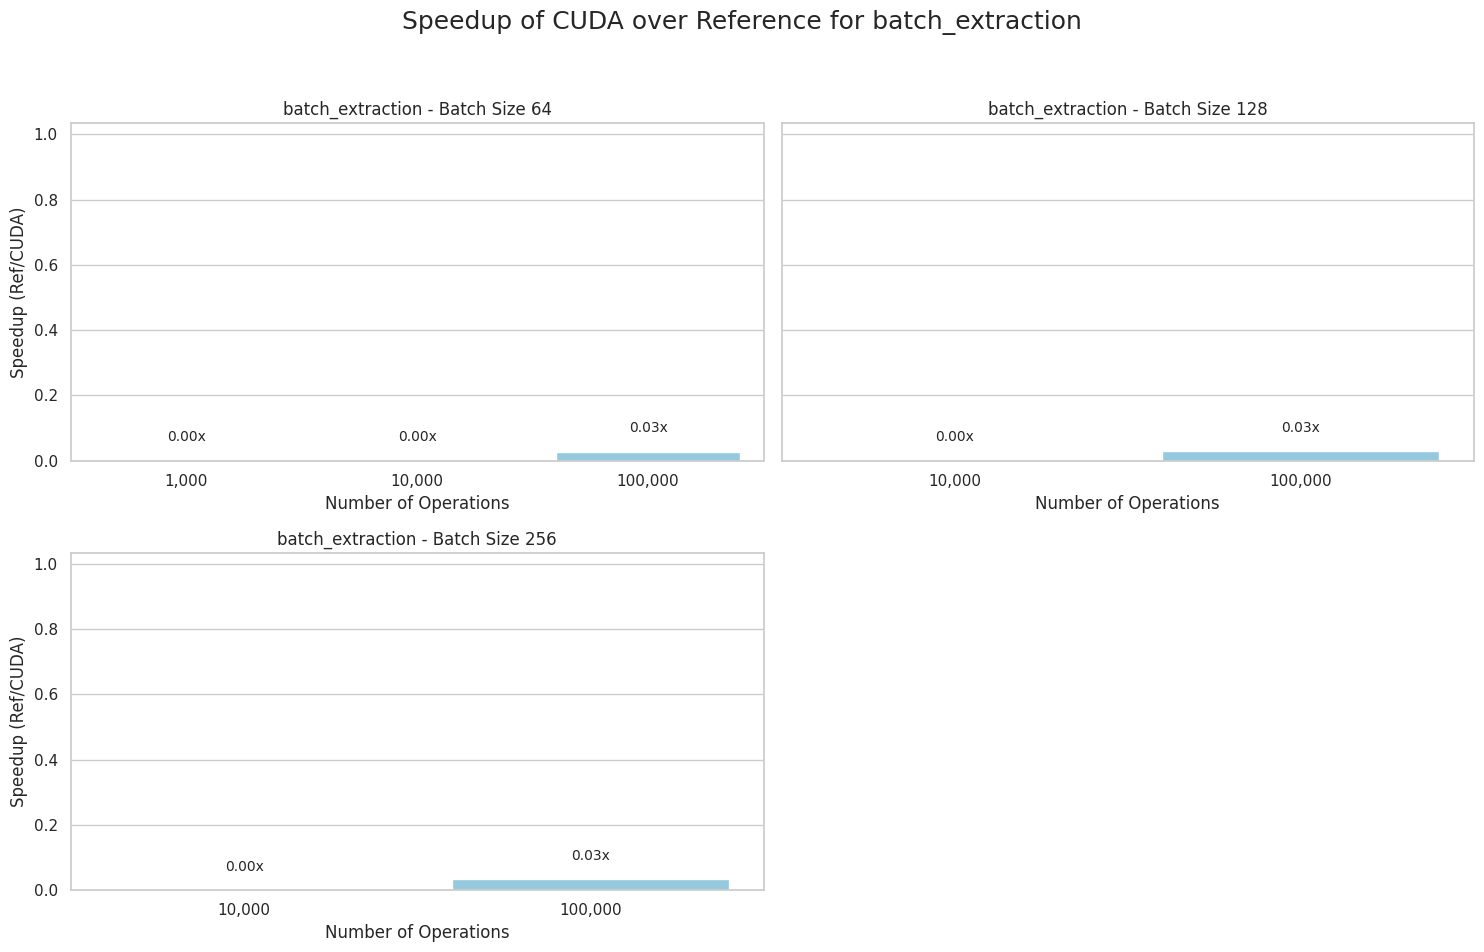

Saved overall plot for batch_insertion: plots/batch_insertion_all_batches_speedup.png


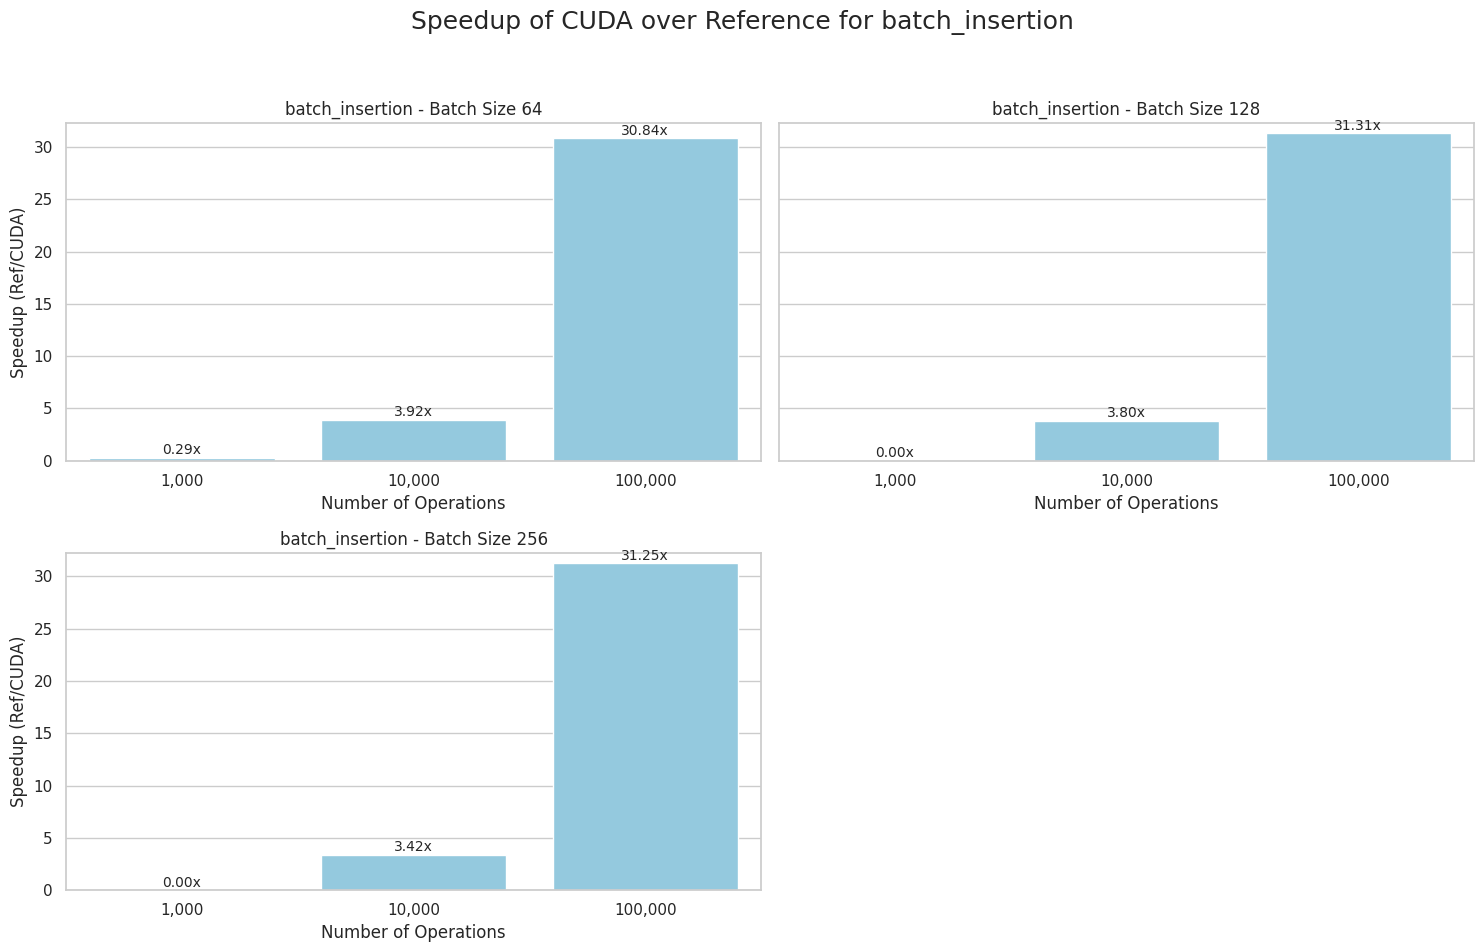

Saved plot: plots/single_extraction_speedup.png


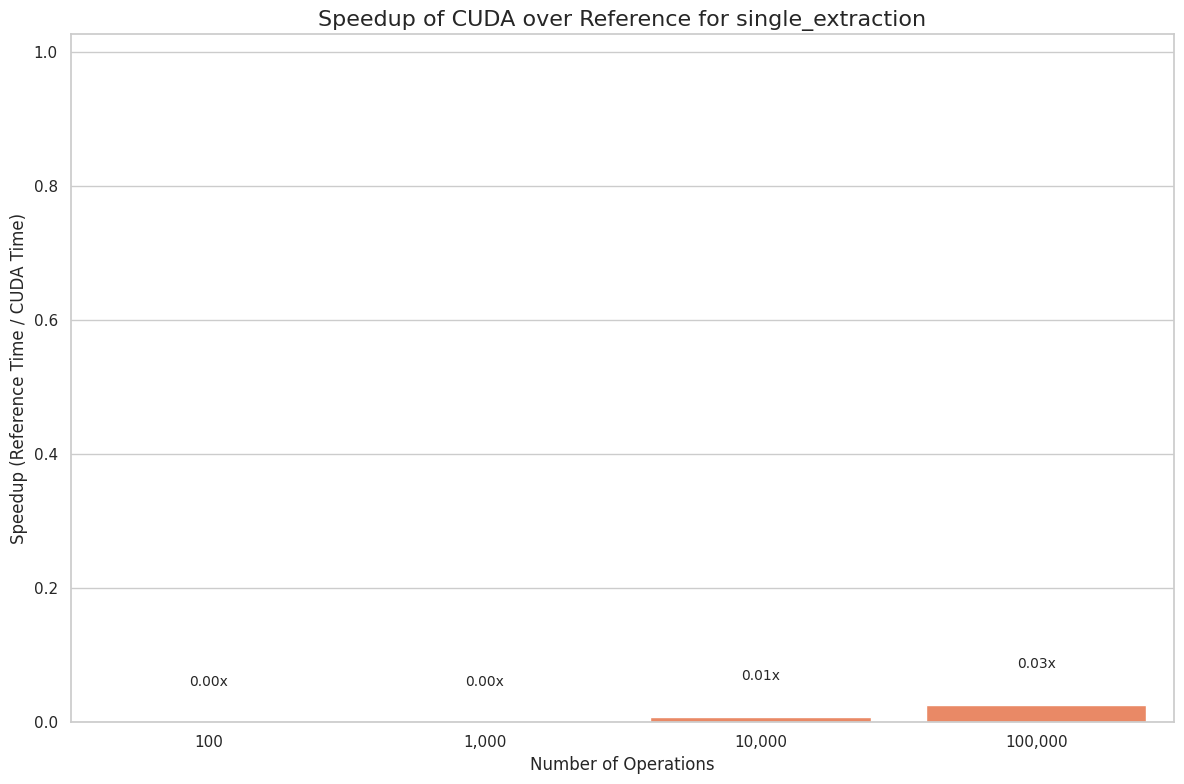

Saved plot: plots/single_insertion_speedup.png


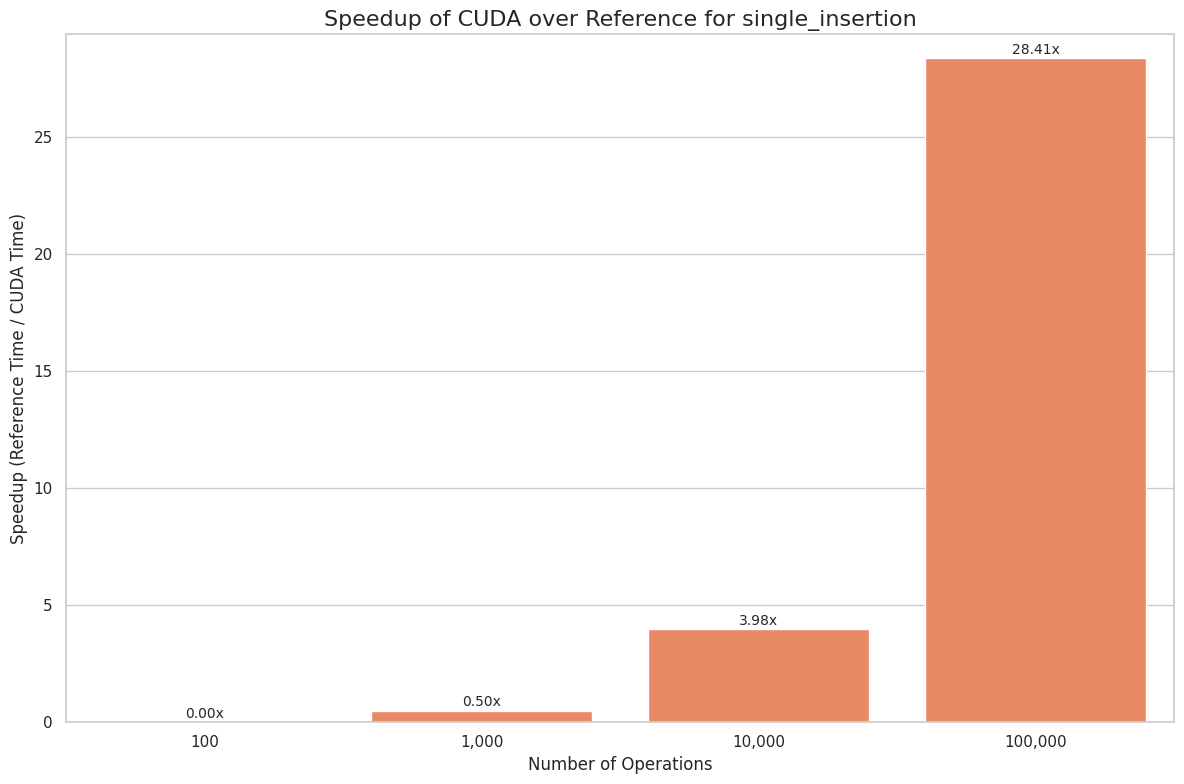

In [16]:
plot_speedup(pivot_df)